# Processing text queries
- code in this notebook predominantly analyze text queries submitted by participants to solve KIS tasks of VBS 2023
- among others, this notebook can replicate the content of Table 2 and 3 as well as Figures 13-15

In [1]:
import sys
import os
modules_path = os.getcwd() + '/..'
sys.path.insert(0, modules_path)


# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from notebooks.utils import compute_user_penalty, get_team_values_df
from common.load import load_competition_data, process_team_logs

pd.set_option('display.max_colwidth', None)
unknownRankLimit = 1000
unknownRankValue = 2000

# Import common data

In [2]:
config = modules_path +'/config_vbs2023.yaml'

# load competition data from dres files and auxiliary data (FPSs, sequences)
comp_data = load_competition_data(config)

# load the preprocessed query data
dataset = pd.read_pickle(comp_data["config"]["processed_logs_outdir"] + '/text_query_dataset.pkl')

# valid teams
team_order = ['vibro', 'VISIONE',  'vitrivr-VR', 'CVHunter', 'Verge']
#team_order = ['vibro', 'VISIONE', 'VIREO' 'vitrivr-VR', 'CVHunter', 'vitrivr', 'Verge']

dataset.shape

D:\projekty\2023\VBS23-Post-Hoc-Analysis-main\VBS23-Post-Hoc-Analysis-main\src\python\notebooks/..\common\tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
D:\projekty\2023\VBS23-Post-Hoc-Analysis-main\VBS23-Post-Hoc-Analysis-main\src\python\notebooks/..\common\tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
D:\projekty\2023\VBS23-Post-Hoc-Analysis-main\VBS23-Post-Hoc-Analysis-main\src\python\notebooks/..\common\tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
D:\projekty\2023\VBS23-Post-Hoc-Analysis-main\VBS23-Post-Hoc-Analysis-main\src\python\notebooks/..\common\tasks.py:59: Fu

(782, 20)

### Creating auxiliary variables
- Query length and volume of words per query
- Maybe also store information whether the query is temporal? Only HTW and VISIONE have obviouse temporal queries
- Define visual vs textual tasks

In [3]:
dataset["task_type"] = "visual"
dataset.loc[dataset.task.str.contains("kis-t"),"task_type"] = "textual"

dataset["QT"] = "Other"
dataset.loc[dataset.is_joint_embedding_text_query, "QT"] = "Text"

dataset["QueryLen"] = -1
dataset["QueryWords"] = -1

dataset.loc[dataset["category"]=="TEXT","QueryLen"] = dataset.loc[dataset["category"]=="TEXT","value"].str.len()
dataset.loc[dataset["category"]=="TEXT","QueryWords"] = dataset.loc[dataset["category"]=="TEXT","value"].str.split().str.len()

dataset.head()

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,...,value,additionals,is_user_with_correct_submission,is_temporal_query,is_joint_embedding_text_query,joint_text_embedding,task_type,QT,QueryLen,QueryWords
0,0,0,vbs23-kis-v1,vibro,0,1673259650000,36687,43981.0,1.0,1.0,...,Man in pink closest standing a basketball stadium,{},NaN,False,True,"[123, 124, -125, -112, -124, -116, -121, 122, -109, 125, -117, -123, 124, -122, 126, -122, -127, 127, 121, -125, 122, -121, 124, 121, -116, 127, -126, -126, -126, 127, 124, -123, 123, -123, -126, 126, 118, 115, 126, -127, 125, 116, 127, 122, 125, -128, 124, -123, -128, -126, -123, 127, -115, -128, -119, 117, -125, 114, 125, -124, -128, -125, 112, 127, 125, 117, 121, -122, -120, -127, 123, 124, 124, 120, 123, 127, -123, 115, 121, 123, -127, -124, 111, 123, 123, -125, 124, 119, -126, 120, -128, -126, -125, 122, 119, 125, 125, 126, -124, -122, ...]",visual,Text,49,8
166,166,166,vbs23-kis-v6,vibro,1,1673279166000,278891,NaN,177.0,665.0,...,paraglider starting flying over mountains with sun and clouds in the background,{},NaN,False,True,"[123, 121, -125, 111, 125, -120, -117, -124, -115, 125, 118, 121, -128, -126, 125, -125, -118, -119, 119, 122, -124, -124, 120, -122, -126, 123, 119, 124, 116, 112, 122, -119, 125, 125, -122, -117, 127, 118, -128, 126, -128, -128, -128, 121, -125, 127, -127, 122, -123, 114, 121, 120, 116, -125, 120, 115, -125, -125, -122, 117, -120, -118, 102, -116, 126, -127, -122, 116, 123, -126, 123, 126, 124, -124, -117, -116, -124, 118, 125, -121, -122, 117, -115, -127, -122, 124, 119, -123, 125, -125, -128, -127, 124, 116, 123, 124, -127, 126, -124, -124, ...]",visual,Text,79,12
165,165,165,vbs23-kis-v6,vibro,1,1673279134000,246891,NaN,44.0,inf,...,video 06651 at 00:02:18.000 (Frame #4135),{},NaN,False,False,None,visual,Other,-1,-1
71,71,71,vbs23-kis-v6,vibro,0,1673279070000,182891,NaN,427.0,inf,...,video 08379 at 00:02:24.000 (Frame #4315),{},NaN,False,False,None,visual,Other,-1,-1
164,164,164,vbs23-kis-v6,vibro,1,1673279113000,225891,NaN,246.0,271.0,...,video 07660 at 00:01:38.000 (Frame #2937),{},NaN,False,False,None,visual,Other,-1,-1


In [4]:
#append dummy values for too high ratings (have to be labeled in plots properly in charts)
dataset.loc[dataset.rank_video > unknownRankLimit,"rank_video"] = unknownRankValue
dataset.loc[dataset.rank_shot_margin_0 > unknownRankLimit,"rank_shot_margin_0"] = unknownRankValue
dataset.loc[dataset.rank_shot_margin_5 > unknownRankLimit,"rank_shot_margin_5"] = unknownRankValue


In [5]:
(dataset.loc[dataset.QT == "Other"]).is_temporal_query.unique()

array([False])

In [6]:
textData = dataset.loc[dataset["QT"]=="Text"]

In [7]:
dataset.shape, textData.shape

((782, 24), (602, 24))

In [8]:
textualMaxTime = 420000
visualMaxTime = 300000
dataset.loc[((dataset.correct_submission_time_ms.isna())&(dataset.task_type=="textual")),"correct_submission_time_ms"] = textualMaxTime
dataset.loc[((dataset.correct_submission_time_ms.isna())&(dataset.task_type=="visual")),"correct_submission_time_ms"] = visualMaxTime

In [9]:
boundaries = [0,60,120,180,240,300,360,420]
boundaries = [b*1000 for b in boundaries]
valid_bins = []
dataset["hist_bin"] = 0

for b in boundaries:
    
    if b > 0:
        # checking whether the team was available throughout the whole period of the bin
        dataset["valid_"+str(b-60*1000)] = (dataset["correct_submission_time_ms"]>=b)
        valid_bins.append("valid_"+str(b-60*1000))
    dataset.loc[dataset.elapsed_since_task_start_ms >= b, "hist_bin"] = b
    
dataset.tail()

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,...,QueryLen,QueryWords,hist_bin,valid_0,valid_60000,valid_120000,valid_180000,valid_240000,valid_300000,valid_360000
1563,42,42,vbs23-kis-t2,Verge,0,1673261197464,300820,420000.0,159.0,159.0,...,16,3,300000,True,True,True,True,True,True,True
1661,140,140,vbs23-kis-t7,Verge,0,1673277558195,26661,114978.0,25.0,2000.0,...,49,10,0,True,False,False,False,False,False,False
1562,41,41,vbs23-kis-t2,Verge,0,1673261171254,274610,420000.0,2000.0,2000.0,...,-1,-1,240000,True,True,True,True,True,True,True
1603,82,82,vbs23-kis-t4,Verge,0,1673262678569,355814,356336.0,139.0,139.0,...,54,9,300000,True,True,True,True,True,False,False
1574,53,53,vbs23-kis-t3,Verge,0,1673261552171,150872,420000.0,2000.0,2000.0,...,11,2,120000,True,True,True,True,True,True,True


# Work with text embeddings

In [10]:
dataset.columns

Index(['level_0', 'index', 'task', 'team', 'user', 'timestamp',
       'elapsed_since_task_start_ms', 'correct_submission_time_ms',
       'rank_video', 'rank_shot_margin_0', 'rank_shot_margin_5', 'max_rank',
       'category', 'type', 'value', 'additionals',
       'is_user_with_correct_submission', 'is_temporal_query',
       'is_joint_embedding_text_query', 'joint_text_embedding', 'task_type',
       'QT', 'QueryLen', 'QueryWords', 'hist_bin', 'valid_0', 'valid_60000',
       'valid_120000', 'valid_180000', 'valid_240000', 'valid_300000',
       'valid_360000'],
      dtype='object')

In [11]:
dataset

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,...,QueryLen,QueryWords,hist_bin,valid_0,valid_60000,valid_120000,valid_180000,valid_240000,valid_300000,valid_360000
0,0,0,vbs23-kis-v1,vibro,0,1673259650000,36687,43981.0,1.0,1.0,...,49,8,0,False,False,False,False,False,False,False
166,166,166,vbs23-kis-v6,vibro,1,1673279166000,278891,300000.0,177.0,665.0,...,79,12,240000,True,True,True,True,True,False,False
165,165,165,vbs23-kis-v6,vibro,1,1673279134000,246891,300000.0,44.0,2000.0,...,-1,-1,240000,True,True,True,True,True,False,False
71,71,71,vbs23-kis-v6,vibro,0,1673279070000,182891,300000.0,427.0,2000.0,...,-1,-1,180000,True,True,True,True,True,False,False
164,164,164,vbs23-kis-v6,vibro,1,1673279113000,225891,300000.0,246.0,271.0,...,-1,-1,180000,True,True,True,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,42,42,vbs23-kis-t2,Verge,0,1673261197464,300820,420000.0,159.0,159.0,...,16,3,300000,True,True,True,True,True,True,True
1661,140,140,vbs23-kis-t7,Verge,0,1673277558195,26661,114978.0,25.0,2000.0,...,49,10,0,True,False,False,False,False,False,False
1562,41,41,vbs23-kis-t2,Verge,0,1673261171254,274610,420000.0,2000.0,2000.0,...,-1,-1,240000,True,True,True,True,True,True,True
1603,82,82,vbs23-kis-t4,Verge,0,1673262678569,355814,356336.0,139.0,139.0,...,54,9,300000,True,True,True,True,True,False,False


In [12]:
dataset.QT

0        Text
166      Text
165     Other
71      Other
164     Other
        ...  
1563     Text
1661     Text
1562    Other
1603     Text
1574     Text
Name: QT, Length: 782, dtype: object

In [13]:
import json
stdf = dataset.loc[dataset.QT=="Text",'joint_text_embedding'].values
stdf = np.stack(stdf)

In [14]:
stdf.shape

(602, 768)

In [15]:
embedColnames = ["f_"+str(i) for i in range(stdf.shape[1])]
dfEmbeds = pd.DataFrame(stdf, columns=embedColnames, index=dataset.loc[dataset.QT=="Text"].index)

In [16]:
jointDF = pd.concat([dataset.loc[dataset.QT=="Text"], dfEmbeds], axis=1)
jointDF

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,...,f_758,f_759,f_760,f_761,f_762,f_763,f_764,f_765,f_766,f_767
0,0,0,vbs23-kis-v1,vibro,0,1673259650000,36687,43981.0,1.0,1.0,...,125,-124,-125,119,127,-125,116,122,-128,-128
166,166,166,vbs23-kis-v6,vibro,1,1673279166000,278891,300000.0,177.0,665.0,...,127,121,-126,-125,121,-123,120,126,127,-125
154,154,154,vbs23-kis-v6,vibro,1,1673278908000,20891,300000.0,68.0,261.0,...,127,119,-119,-123,117,-118,115,125,-126,-120
153,153,153,vbs23-kis-v6,vibro,1,1673278900000,12891,300000.0,355.0,2000.0,...,-127,125,-126,-127,118,-121,116,126,-125,-121
150,150,150,vbs23-kis-v5,vibro,1,1673278562000,15759,44588.0,36.0,2000.0,...,126,-127,-128,125,127,127,127,-125,125,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1602,81,81,vbs23-kis-t4,Verge,0,1673262678569,355814,356336.0,139.0,139.0,...,-124,126,121,119,124,-127,-125,121,123,120
1563,42,42,vbs23-kis-t2,Verge,0,1673261197464,300820,420000.0,159.0,159.0,...,126,-123,124,-126,127,127,127,-126,120,-128
1661,140,140,vbs23-kis-t7,Verge,0,1673277558195,26661,114978.0,25.0,2000.0,...,-128,118,118,127,121,120,-125,123,-127,116
1603,82,82,vbs23-kis-t4,Verge,0,1673262678569,355814,356336.0,139.0,139.0,...,-124,123,-127,120,122,124,-124,-122,-128,127


In [17]:
jointDF.task.unique()

array(['vbs23-kis-v1', 'vbs23-kis-v6', 'vbs23-kis-v5', 'vbs23-kis-t7',
       'vbs23-kis-v-m4', 'vbs23-kis-v-m5', 'vbs23-kis-v-m7',
       'vbs23-kis-v2', 'vbs23-kis-v3', 'vbs23-kis-v4', 'vbs23-kis-t3',
       'vbs23-kis-v-m3', 'vbs23-kis-v-m2', 'vbs23-kis-t6', 'vbs23-kis-t5',
       'vbs23-kis-t4', 'vbs23-kis-t1', 'vbs23-kis-t2', 'vbs23-kis-v-m1'],
      dtype=object)

In [18]:
from sklearn.metrics import pairwise_distances
def upper_tri_indexing(A):
    m = A.shape[0]
    r,c = np.triu_indices(m,1)
    return A[r,c]

def ILD(dataset, columns):
    dt = dataset[columns].values
    if len(dt)==0:
        return (np.empty(shape=(0, 0)), 0)
    distMatrix = pairwise_distances(dt,metric="cosine")
    #remove distances to self
    distMatrix = upper_tri_indexing(distMatrix)
    return (distMatrix,distMatrix.mean())


In [19]:
upper_tri_indexing(np.array([[1,2,3],[4,5,6],[7,8,9]]))

array([2, 3, 6])

### How does query distances differ for individual tasks?

In [20]:
dMats0 = {}
for t in jointDF.task.unique():    
    distMatrix, meanVal = ILD(jointDF.loc[jointDF["task"]==t],embedColnames)
    dMats0[t] = distMatrix.ravel()
    print (t, meanVal)
dMats0 = pd.Series(dMats0)

vbs23-kis-v1 0.7415215063535081
vbs23-kis-v6 0.596126376261142
vbs23-kis-v5 0.6030049614025474
vbs23-kis-t7 0.6314706804321577
vbs23-kis-v-m4 0.6476670479842503
vbs23-kis-v-m5 0.7135961389988481
vbs23-kis-v-m7 0.6365285675236477
vbs23-kis-v2 0.6930947507749152
vbs23-kis-v3 0.6583870667461167
vbs23-kis-v4 0.6596587598240271
vbs23-kis-t3 0.49012292939646124
vbs23-kis-v-m3 0.788559162936822
vbs23-kis-v-m2 0.6395754960912675
vbs23-kis-t6 0.7378005955848885
vbs23-kis-t5 0.6767089769903584
vbs23-kis-t4 0.6165193475866779
vbs23-kis-t1 0.5399711969482114
vbs23-kis-t2 0.7543498428962476
vbs23-kis-v-m1 0.6371778778661307


In [21]:
textTasks = [i for i in jointDF.task.unique() if "kis-t" in i]
visualTasks = [i for i in jointDF.task.unique() if (("kis-v-" not in i)&("kis-v" in i))]
marineTasks = [i for i in jointDF.task.unique() if "kis-v-" in i]

### Textual tasks have smaller between-query distances than both visual ones
- also marine tasks has slightly smaller distances than V3C1 visual ones

In [22]:
print(np.concatenate(dMats0[textTasks].values).mean())
print(np.concatenate(dMats0[visualTasks].values).mean())
print(np.concatenate(dMats0[marineTasks].values).mean())

0.599125437535578
0.6671994135181483
0.6540511521282495


In [23]:
np.concatenate(dMats0[textTasks].values).shape

(6347,)

In [24]:
from scipy.stats import ttest_ind
print(ttest_ind(np.concatenate(dMats0[textTasks].values),np.concatenate(dMats0[visualTasks].values)))
print(ttest_ind(np.concatenate(dMats0[textTasks].values),np.concatenate(dMats0[marineTasks].values)))
print(ttest_ind(np.concatenate(dMats0[marineTasks].values),np.concatenate(dMats0[visualTasks].values)))

Ttest_indResult(statistic=-18.682347668685775, pvalue=1.44817513974304e-76)
Ttest_indResult(statistic=-11.394679596198705, pvalue=7.533785247517767e-30)
Ttest_indResult(statistic=-2.599720959868566, pvalue=0.009356551925173793)


In [25]:
txt = pd.DataFrame({"v": np.concatenate(dMats0[textTasks].values)})
txt["type"]="Textual"
vis = pd.DataFrame({"v": np.concatenate(dMats0[visualTasks].values)})
vis["type"]="Visual"
mar = pd.DataFrame({"v": np.concatenate(dMats0[marineTasks].values)})
mar["type"]="Marine Visual"
dfPlot = pd.concat([txt,vis,mar])

<AxesSubplot:xlabel='type', ylabel='v'>

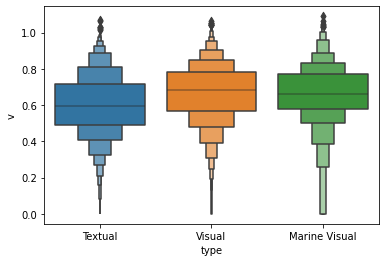

In [26]:
sns.boxenplot(y=dfPlot["v"],x=dfPlot["type"])

In [27]:
mar["v"].mean()

0.6540511521282496

## Team-wise differences

In [28]:
dMats = {}
for t in jointDF.task.unique():
    for tm in jointDF.team.unique():
        distMatrix, meanVal = ILD(jointDF.loc[((jointDF["task"]==t)&(jointDF["team"]==tm))],embedColnames)
        dMats[(t,tm)] = distMatrix.ravel()
        print (t, tm, meanVal)
dMats = pd.Series(dMats)

vbs23-kis-v1 vibro 0.62438984020422
vbs23-kis-v1 VISIONE 0.882786915520282
vbs23-kis-v1 vitrivr-VR 0.546614305360363
vbs23-kis-v1 CVHunter 0.6508291445043268
vbs23-kis-v1 Verge 0.7370750940406298
vbs23-kis-v6 vibro 0.3623086854731705
vbs23-kis-v6 VISIONE 0.46907874371584446
vbs23-kis-v6 vitrivr-VR 0.6850736421880917
vbs23-kis-v6 CVHunter 0.44058749894928095
vbs23-kis-v6 Verge 0.5692776368927122
vbs23-kis-v5 vibro 0.628133720162357
vbs23-kis-v5 VISIONE 0.4494470349746992
vbs23-kis-v5 vitrivr-VR 0.7756067501060895
vbs23-kis-v5 CVHunter 0.5512382454517226
vbs23-kis-v5 Verge 0.45171354333109776
vbs23-kis-t7 vibro 0.41192323774403006
vbs23-kis-t7 VISIONE 0.5267314939003283
vbs23-kis-t7 vitrivr-VR 0.5301626689973135
vbs23-kis-t7 CVHunter 0.5580075228184775
vbs23-kis-t7 Verge 0.8117558667714109
vbs23-kis-v-m4 vibro 0.45778235380740134
vbs23-kis-v-m4 VISIONE 0.6180691585799387
vbs23-kis-v-m4 vitrivr-VR 0.5287287084759074
vbs23-kis-v-m4 CVHunter 0.5372833133981153
vbs23-kis-v-m4 Verge 0
vbs23-k

<ipython-input-18-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
C:\Users\lpeska\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-18-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
C:\Users\lpeska\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-18-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
C:\Users\lpeska\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-18-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMa

In [29]:

for tm in jointDF.team.unique():
    keys = list(np.broadcast(jointDF.task.unique(),tm))

    print(tm, np.concatenate(dMats[keys].values).mean())

vibro 0.49534756994645324
VISIONE 0.47336383636942464
vitrivr-VR 0.6805805618096368
CVHunter 0.5561263176089748
Verge 0.644893782338457


In [30]:
task = []
team = []
distance = []

for t in jointDF.task.unique():
    for tm in jointDF.team.unique():
        #print(t,tm,np.mean(dMats[(t,tm)]))
        for d in dMats[(t,tm)]:
            task.append(t)
            team.append(tm)
            distance.append(d)
dfGraph2 = pd.DataFrame({"task":task, "team":team,"distance":distance})
dfGraph2.head()

,task,team,distance
0,vbs23-kis-v1,vibro,0.845358
1,vbs23-kis-v1,vibro,0.752161
2,vbs23-kis-v1,vibro,0.592248
3,vbs23-kis-v1,vibro,0.328448
4,vbs23-kis-v1,vibro,0.679254


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'vbs23-kis-t1'),
  Text(1, 0, 'vbs23-kis-t2'),
  Text(2, 0, 'vbs23-kis-t3'),
  Text(3, 0, 'vbs23-kis-t4'),
  Text(4, 0, 'vbs23-kis-t5'),
  Text(5, 0, 'vbs23-kis-t6'),
  Text(6, 0, 'vbs23-kis-t7'),
  Text(7, 0, 'vbs23-kis-v-m1'),
  Text(8, 0, 'vbs23-kis-v-m2'),
  Text(9, 0, 'vbs23-kis-v-m3'),
  Text(10, 0, 'vbs23-kis-v-m4'),
  Text(11, 0, 'vbs23-kis-v-m5'),
  Text(12, 0, 'vbs23-kis-v-m7'),
  Text(13, 0, 'vbs23-kis-v1'),
  Text(14, 0, 'vbs23-kis-v2'),
  Text(15, 0, 'vbs23-kis-v3'),
  Text(16, 0, 'vbs23-kis-v4'),
  Text(17, 0, 'vbs23-kis-v5'),
  Text(18, 0, 'vbs23-kis-v6')])

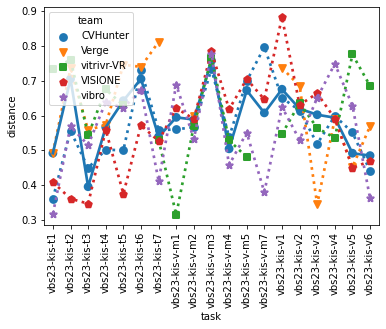

In [31]:
dfGraph2 = dfGraph2.sort_values("task")
dfGraph2
sns.pointplot(data=dfGraph2, x="task", y="distance", hue="team", markers=["o","v","s","p","*"], errorbar=None, linestyles="dotted")
sns.pointplot(data=dfGraph2, x="task", y="distance", markers=["o","v","s","p","*"], errorbar=None)

plt.xticks(rotation=90)

In [32]:
task = []
team = []
distance = []

for t in jointDF.task.unique():
    for tm in jointDF.team.unique():
        #print(t,tm,np.mean(dMats[(t,tm)]))
        task.append(t)
        team.append(tm)
        
        distance.append(dMats[(t,tm)].mean())
dfGraph = pd.DataFrame({"task":task, "team":team,"mean distance":distance})
dfGraph.head()

<ipython-input-32-194f613f3f62>:11: RuntimeWarning: Mean of empty slice.
  distance.append(dMats[(t,tm)].mean())
C:\Users\lpeska\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,task,team,mean distance
0,vbs23-kis-v1,vibro,0.624390
1,vbs23-kis-v1,VISIONE,0.882787
2,vbs23-kis-v1,vitrivr-VR,0.546614
3,vbs23-kis-v1,CVHunter,0.650829
4,vbs23-kis-v1,Verge,0.737075


In [33]:
dfGraph = dfGraph.sort_values("task")
dfGraph

,task,team,mean distance
83,vbs23-kis-t1,CVHunter,0.361329
84,vbs23-kis-t1,Verge,0.492682
82,vbs23-kis-t1,vitrivr-VR,0.733195
81,vbs23-kis-t1,VISIONE,0.408556
80,vbs23-kis-t1,vibro,0.317044
...,...,...,...
9,vbs23-kis-v6,Verge,0.569278
8,vbs23-kis-v6,CVHunter,0.440587
7,vbs23-kis-v6,vitrivr-VR,0.685074
6,vbs23-kis-v6,VISIONE,0.469079


In [34]:
dfGraph["task"] = dfGraph["task"].str.replace("vbs23-","")
dfGraph["task"] = dfGraph["task"].str.replace("kis-v-m","KIS-V-M")
dfGraph["task"] = dfGraph["task"].str.replace("kis-v","KIS-V")
dfGraph["task"] = dfGraph["task"].str.replace("kis-t","KIS-T")

In [35]:
import itertools

In [36]:
hue_order = ['vibro', 'VISIONE', "vitrivr-VR","CVHunter",'Verge']
txtTasks = list(itertools.product(textTasks,hue_order))
marTasks = list(itertools.product(marineTasks,hue_order))
visTasks = list(itertools.product(visualTasks,hue_order))
#val = np.concatenate(dMats[txtTasks].values).mean()

In [37]:
res = []
for k in txtTasks:
    try:
        res.extend(dMats[k])
    except:
        print("not found key",k)
txtMean = np.mean(res)
txtAll = res
print(len(res),np.mean(res))

1568 0.5299266882818374


In [38]:
res = []
for k in marTasks:
    try:
        res.extend(dMats[k])
    except:
        print("not found key",k)
marMean = np.mean(res)
marAll = res
print(len(res),np.mean(res))

522 0.5562347564831921


In [39]:
res = []
for k in visTasks:
    try:
        res.extend(dMats[k])
    except:
        print("not found key",k)
visMean = np.mean(res)
visAll = res
print(len(res),np.mean(res))

926 0.5902078448861199


In [40]:
print(ttest_ind(txtAll,marAll))
print(ttest_ind(txtAll,visAll))
print(ttest_ind(marAll,visAll))

Ttest_indResult(statistic=-2.440180071324053, pvalue=0.014762598690012023)
Ttest_indResult(statistic=-7.065761378231396, pvalue=2.064637822862483e-12)
Ttest_indResult(statistic=-3.0035482958445456, pvalue=0.002714357089373528)


In [41]:
team2color = {
    'vibro'     : '#1f77b4',
    'VISIONE'   : '#ff7f0e',
    'VIREO'     : '#2ca02c',
    'vitrivr-VR': '#d62728',
    'CVHunter'  : '#9467bd',
    'vitrivr'   : '#8c564b',
    'Verge'     : '#e377c2',
}

team2marker = {
    'vibro'     : 'D',
    'VISIONE'   : 'X',
    'VIREO'     : 'o', 
    'vitrivr-VR': '*',
    'CVHunter'  : 'd',
    'vitrivr'   : 'P',
    'Verge'     : 's',
}

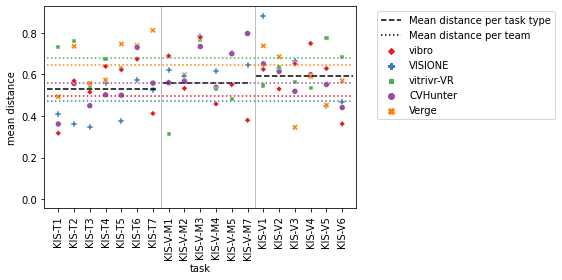

In [42]:
import matplotlib.patches as mpatches
plt.subplots(1,1,figsize=(8,4))
dfGraph = dfGraph.sort_values("task")
hue_order = ['vibro', 'VISIONE', "vitrivr-VR","CVHunter",'Verge']

custom_palette = sns.color_palette("Set1", 5)
plt.axvline(x = 6.5, color="grey", lw=0.5)
plt.axvline(x = 12.5, color="grey", lw=0.5)

sns.scatterplot(data=dfGraph, x="task", y="mean distance", hue="team", hue_order=hue_order, style="team", palette=custom_palette)
plt.xticks(rotation=90)




plt.axhline(y = txtMean, xmin = 0.01, xmax = 0.36, color="black", linestyle = '--', label="Mean distance per task type")
plt.axhline(y = marMean, xmin = 0.38, xmax = 0.66, color="black", linestyle = '--')
plt.axhline(y = visMean, xmin = 0.68, xmax = 0.99, color="black", linestyle = '--')

#plt.axhline(y = np.concatenate(dMats0[textTasks].values).mean(), xmin = 0.01, xmax = 0.36, color="black", linestyle = '--', label="Mean distance per task type")
#plt.axhline(y = np.concatenate(dMats0[marineTasks].values).mean(), xmin = 0.38, xmax = 0.66, color="black", linestyle = '--')
#plt.axhline(y = np.concatenate(dMats0[visualTasks].values).mean(), xmin = 0.68, xmax = 0.99, color="black", linestyle = '--')
plt.axhline(y = 0, xmin = 0.00, xmax = 0.00, color="black", linestyle = ':', label="Mean distance per team")


i = 0
for tm in ['vibro', 'VISIONE', "vitrivr-VR","CVHunter",'Verge']:
    keys = list(np.broadcast(jointDF.task.unique(),tm))
    val = np.concatenate(dMats[keys].values).mean()
    plt.axhline(y = val, xmin = 0.01, xmax = 0.99, color=custom_palette[i], linestyle = ':')
    
    i=i+1



plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig("distances.pdf")

['vbs23-kis-t7', 'vbs23-kis-t3', 'vbs23-kis-t6', 'vbs23-kis-t5', 'vbs23-kis-t4', 'vbs23-kis-t1', 'vbs23-kis-t2']
['vbs23-kis-v-m4', 'vbs23-kis-v-m5', 'vbs23-kis-v-m7', 'vbs23-kis-v-m3', 'vbs23-kis-v-m2', 'vbs23-kis-v-m1']
['vbs23-kis-v1', 'vbs23-kis-v6', 'vbs23-kis-v5', 'vbs23-kis-v2', 'vbs23-kis-v3', 'vbs23-kis-v4']


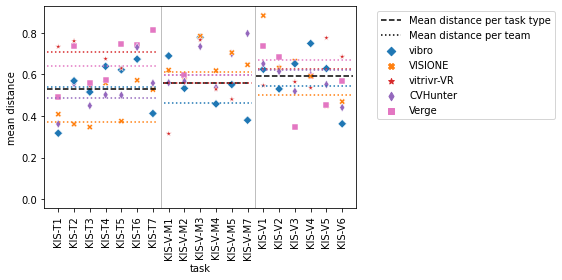

In [43]:
import matplotlib.patches as mpatches
plt.subplots(1,1,figsize=(8,4))
dfGraph = dfGraph.sort_values("task")
hue_order = ['vibro', 'VISIONE', "vitrivr-VR","CVHunter",'Verge']

custom_palette = sns.color_palette("Set1", 5)
plt.axvline(x = 6.5, color="grey", lw=0.5)
plt.axvline(x = 12.5, color="grey", lw=0.5)

sns.scatterplot(data=dfGraph, x="task", y="mean distance", hue="team", hue_order=hue_order, style="team", palette=team2color, markers=team2marker)
plt.xticks(rotation=90)




plt.axhline(y = txtMean, xmin = 0.01, xmax = 0.36, color="black", linestyle = '--', label="Mean distance per task type")
plt.axhline(y = marMean, xmin = 0.38, xmax = 0.66, color="black", linestyle = '--')
plt.axhline(y = visMean, xmin = 0.68, xmax = 0.99, color="black", linestyle = '--')

plt.axhline(y = 0, xmin = 0.00, xmax = 0.00, color="black", linestyle = ':', label="Mean distance per team")


j=0
posStart = [0.01, 0.385, 0.685]
posEnd = [0.365, 0.665, 0.99]
for tasks in [textTasks,marineTasks,visualTasks]:
    print(tasks)
    i = 0
    for tm in ['vibro', 'VISIONE', "vitrivr-VR","CVHunter",'Verge']:
        keys = list(np.broadcast(tasks,tm))
        val = np.concatenate(dMats[keys].values).mean()
        plt.axhline(y = val, xmin = posStart[j], xmax = posEnd[j], color=team2color[tm], linestyle = ':')

        i=i+1
    j = j+1


plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig("distances_v2.pdf")

### Both vibro and VISIONE had more consistent per-task queries than CVHunter
- comparison with other teams omitted due to missing data

In [44]:
print(ttest_ind(np.concatenate(dMats[list(np.broadcast(jointDF.task.unique(),"vibro"))].values),np.concatenate(dMats[list(np.broadcast(jointDF.task.unique(),"CVHunter"))].values)))
print(ttest_ind(np.concatenate(dMats[list(np.broadcast(jointDF.task.unique(),"VISIONE"))].values),np.concatenate(dMats[list(np.broadcast(jointDF.task.unique(),"CVHunter"))].values)))
print(ttest_ind(np.concatenate(dMats[list(np.broadcast(jointDF.task.unique(),"vibro"))].values),np.concatenate(dMats[list(np.broadcast(jointDF.task.unique(),"VISIONE"))].values)))

Ttest_indResult(statistic=-4.743807582805333, pvalue=2.3720518233130858e-06)
Ttest_indResult(statistic=-9.237167666629611, pvalue=6.910665040234527e-20)
Ttest_indResult(statistic=1.625441285418206, pvalue=0.10431132119897231)


## Comparison of both users per team and task

In [45]:
jointDF.groupby(["team","user"]).count()["task"]

team        user
CVHunter    0        76
            1        71
VISIONE     0        47
            1       110
Verge       0       121
vibro       0        37
            1        49
vitrivr-VR  0        56
            1        35
Name: task, dtype: int64

- removing verge as no distinction between users is available
- several times, vitrivr-VR does not have any records from one of the users (candidate for removal)

In [46]:
jointDFNoVerge = jointDF.loc[jointDF.team != "Verge"]
jointDF.shape,jointDFNoVerge.shape

((602, 800), (481, 800))

In [47]:
def ILD_pair(dataset1, dataset2, columns):
    dt1 = dataset1[columns].values
    dt2 = dataset2[columns].values
    if (len(dt1)==0)|(len(dt2)==0):
        return (np.empty(shape=(0, 0)), 0)
    distMatrix = pairwise_distances(dt1,dt2,metric="cosine")
    return (distMatrix.flatten(),distMatrix.mean())

In [48]:
dMats = {}
for t in jointDFNoVerge.task.unique():
    for tm in jointDFNoVerge.team.unique():
        dt1 = jointDFNoVerge.loc[((jointDFNoVerge["task"]==t)&(jointDFNoVerge["team"]==tm)&(jointDFNoVerge["user"]==0))]
        dt2 = jointDFNoVerge.loc[((jointDFNoVerge["task"]==t)&(jointDFNoVerge["team"]==tm)&(jointDFNoVerge["user"]==1))] 
        
        distMatrix, meanVal = ILD_pair(dt1, dt2, embedColnames)
        dMats[(t,tm)] = distMatrix.ravel()
        print (t, tm, meanVal)
dMats = pd.Series(dMats)

vbs23-kis-v1 vibro 0.7299225463886151
vbs23-kis-v1 VISIONE 0.882786915520282
vbs23-kis-v1 vitrivr-VR 0.6870587435670761
vbs23-kis-v1 CVHunter 0.7302483775459264
vbs23-kis-v6 vibro 0.3969720728491262
vbs23-kis-v6 VISIONE 0.5600905870712753
vbs23-kis-v6 vitrivr-VR 0.7507866975001081
vbs23-kis-v6 CVHunter 0.5803127697777954
vbs23-kis-v5 vibro 0.7477012411123647
vbs23-kis-v5 VISIONE 0.5482587967079215
vbs23-kis-v5 vitrivr-VR 0.7756067501060894
vbs23-kis-v5 CVHunter 0.6486346769877094
vbs23-kis-t7 vibro 0.36767081787544525
vbs23-kis-t7 VISIONE 0.6742433613446713
vbs23-kis-t7 vitrivr-VR 0.5301626689973135
vbs23-kis-t7 CVHunter 0.7123249047077747
vbs23-kis-v-m4 vibro 0.6023711039587771
vbs23-kis-v-m4 VISIONE 0.6959449109870126
vbs23-kis-v-m4 vitrivr-VR 0.6908217517159061
vbs23-kis-v-m4 CVHunter 0.6315031924718134
vbs23-kis-v-m5 vibro 0.6363430175800942
vbs23-kis-v-m5 VISIONE 0.7999227240761061
vbs23-kis-v-m5 vitrivr-VR 0.468125971547914
vbs23-kis-v-m5 CVHunter 0.699259703655281
vbs23-kis-v-m7

In [49]:
vals = []
for tm in jointDFNoVerge.team.unique():
    keys = list(np.broadcast(jointDFNoVerge.task.unique(),tm))
    print(tm, np.concatenate(dMats[keys].values).mean())
    vals.extend(np.concatenate(dMats[keys].values))
np.mean(vals)

vibro 0.5823189551382467
VISIONE 0.5463885036644432
vitrivr-VR 0.7053707428195742
CVHunter 0.6337494029541246


0.6054884347707357

- not so much different from the results of the overall distances (just a bit higher values)

In [50]:
dMats2 = {}
for t in jointDFNoVerge.task.unique():
    for tm in jointDFNoVerge.team.unique():
        for u in jointDFNoVerge.user.unique():
            distMatrix, meanVal = ILD(jointDFNoVerge.loc[((jointDFNoVerge["task"]==t)&(jointDFNoVerge["team"]==tm)&(jointDFNoVerge["user"]==u))],embedColnames)
            dMats2[(t,tm,u)] = distMatrix.ravel()
            print (t, tm,u, meanVal)
dMats2 = pd.Series(dMats2)

vbs23-kis-v1 vibro 0 nan
vbs23-kis-v1 vibro 1 0.5188571340198246
vbs23-kis-v1 VISIONE 0 nan
vbs23-kis-v1 VISIONE 1 nan
vbs23-kis-v1 vitrivr-VR 0 0.4529846798892209
vbs23-kis-v1 vitrivr-VR 1 nan
vbs23-kis-v1 CVHunter 0 0.6057241030515249
vbs23-kis-v1 CVHunter 1 0.5086623637163303
vbs23-kis-v6 vibro 0 0.23920332946250109
vbs23-kis-v6 vibro 1 0.46986584799068654
vbs23-kis-v6 VISIONE 0 0.31483772512257846
vbs23-kis-v6 VISIONE 1 0.4486723035707318
vbs23-kis-v6 vitrivr-VR 0 0.7040993537399071
vbs23-kis-v6 vitrivr-VR 1 0.3841699978363961
vbs23-kis-v6 CVHunter 0 nan
vbs23-kis-v6 CVHunter 1 0.3474373183969379
vbs23-kis-v5 vibro 0 0.3889986782623416
vbs23-kis-v5 vibro 1 nan
vbs23-kis-v5 VISIONE 0 0.5350863641313233
vbs23-kis-v5 VISIONE 1 0.30342479780429876
vbs23-kis-v5 vitrivr-VR 0 nan
vbs23-kis-v5 vitrivr-VR 1 nan
vbs23-kis-v5 CVHunter 0 0.3564453823797492
vbs23-kis-v5 CVHunter 1 nan
vbs23-kis-t7 vibro 0 nan
vbs23-kis-t7 vibro 1 0.4561756576126144
vbs23-kis-t7 VISIONE 0 0.32151179343017583
vbs

<ipython-input-18-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
C:\Users\lpeska\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-18-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
C:\Users\lpeska\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-18-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
C:\Users\lpeska\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-18-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMa

 nan
vbs23-kis-v-m7 vibro 1 nan
vbs23-kis-v-m7 VISIONE 0 nan
vbs23-kis-v-m7 VISIONE 1 nan
vbs23-kis-v-m7 vitrivr-VR 0 nan
vbs23-kis-v-m7 vitrivr-VR 1 0
vbs23-kis-v-m7 CVHunter 0 nan
vbs23-kis-v-m7 CVHunter 1 nan
vbs23-kis-v2 vibro 0 0.4671968038099713
vbs23-kis-v2 vibro 1 nan
vbs23-kis-v2 VISIONE 0 0.263859565078062
vbs23-kis-v2 VISIONE 1 0.5828392572390042
vbs23-kis-v2 vitrivr-VR 0 0.46694353978266223
vbs23-kis-v2 vitrivr-VR 1 nan
vbs23-kis-v2 CVHunter 0 0.48796484024868253
vbs23-kis-v2 CVHunter 1 0.5069438832609234
vbs23-kis-v3 vibro 0 0.5675091380842248
vbs23-kis-v3 vibro 1 0.6772114147229532
vbs23-kis-v3 VISIONE 0 nan
vbs23-kis-v3 VISIONE 1 0.595086446423487
vbs23-kis-v3 vitrivr-VR 0 nan
vbs23-kis-v3 vitrivr-VR 1 nan
vbs23-kis-v3 CVHunter 0 0.48377876981367607
vbs23-kis-v3 CVHunter 1 0.40703918346248485
vbs23-kis-v4 vibro 0 nan
vbs23-kis-v4 vibro 1 nan
vbs23-kis-v4 VISIONE 0 0.3566171997131631
vbs23-kis-v4 VISIONE 1 nan
vbs23-kis-v4 vitrivr-VR 0 0.4958268494809926
vbs23-kis-v4 vitr

<ipython-input-18-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
C:\Users\lpeska\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-18-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
C:\Users\lpeska\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-18-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
C:\Users\lpeska\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-18-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMa

vbs23-kis-t1 VISIONE 0 nan
vbs23-kis-t1 VISIONE 1 0.4870427435627429
vbs23-kis-t1 vitrivr-VR 0 0.6201676641608682
vbs23-kis-t1 vitrivr-VR 1 0.7662454516439493
vbs23-kis-t1 CVHunter 0 0.40057610797406873
vbs23-kis-t1 CVHunter 1 0.2812761885109866
vbs23-kis-t2 vibro 0 nan
vbs23-kis-t2 vibro 1 nan
vbs23-kis-t2 VISIONE 0 nan
vbs23-kis-t2 VISIONE 1 0.359776295870965
vbs23-kis-t2 vitrivr-VR 0 0.7599634278979747
vbs23-kis-t2 vitrivr-VR 1 0.6475420605747879
vbs23-kis-t2 CVHunter 0 0.3424160671947555
vbs23-kis-t2 CVHunter 1 nan
vbs23-kis-v-m1 vibro 0 nan
vbs23-kis-v-m1 vibro 1 nan
vbs23-kis-v-m1 VISIONE 0 0.45946990976815016
vbs23-kis-v-m1 VISIONE 1 0.5560189658661708
vbs23-kis-v-m1 vitrivr-VR 0 nan
vbs23-kis-v-m1 vitrivr-VR 1 nan
vbs23-kis-v-m1 CVHunter 0 0.4825956280943776
vbs23-kis-v-m1 CVHunter 1 0.478289012970608


C:\Users\lpeska\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-18-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
C:\Users\lpeska\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-18-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
C:\Users\lpeska\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-18-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
C:\Users\lpeska\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:190: RuntimeWar

In [51]:
vals=[]
for tm in jointDFNoVerge.team.unique():
    keys = list(np.broadcast(jointDFNoVerge.task.unique(),tm))
    users = [0]*len(keys)+[1]*len(keys)
    keys = [(keys[i%len(keys)][0],keys[i%len(keys)][1],val) for i,val in enumerate(users)]
    print(tm, np.concatenate(dMats2[keys].values).mean())
    vals.extend(np.concatenate(dMats2[keys].values))
np.mean(vals)    

vibro 0.4030514060694479
VISIONE 0.4264451868718016
vitrivr-VR 0.6561276621739842
CVHunter 0.46619204399671793


0.4618813761427707

- quite a few NaNs due to having only a single query per user

In [52]:
dMats3 = {}
for t in jointDFNoVerge.task.unique():
    for tm in jointDFNoVerge.team.unique():
        dt1 = jointDFNoVerge.loc[((jointDFNoVerge["task"]==t)&(jointDFNoVerge["team"]==tm))]
        
        for tm2 in jointDFNoVerge.team.unique():
            if tm2!= tm:
                dt2_1 = jointDFNoVerge.loc[((jointDFNoVerge["task"]==t)&(jointDFNoVerge["team"]==tm2))]                                
                distMatrix, meanVal = ILD_pair(dt1, dt2_1, embedColnames)
                dMats3[(t,tm,tm2)] = distMatrix.ravel()
                print (t, tm,tm2, meanVal)
dMats3 = pd.Series(dMats3)

vbs23-kis-v1 vibro VISIONE 0.7969838498508867
vbs23-kis-v1 vibro vitrivr-VR 0.6624731633674168
vbs23-kis-v1 vibro CVHunter 0.7314777078859137
vbs23-kis-v1 VISIONE vibro 0.7969838498508867
vbs23-kis-v1 VISIONE vitrivr-VR 0.8026617970805343
vbs23-kis-v1 VISIONE CVHunter 0.8129986504289225
vbs23-kis-v1 vitrivr-VR vibro 0.6624731633674167
vbs23-kis-v1 vitrivr-VR VISIONE 0.8026617970805343
vbs23-kis-v1 vitrivr-VR CVHunter 0.6561291764886202
vbs23-kis-v1 CVHunter vibro 0.7314777078859137
vbs23-kis-v1 CVHunter VISIONE 0.8129986504289224
vbs23-kis-v1 CVHunter vitrivr-VR 0.6561291764886203
vbs23-kis-v6 vibro VISIONE 0.5952473769965433
vbs23-kis-v6 vibro vitrivr-VR 0.6000036071689684
vbs23-kis-v6 vibro CVHunter 0.5203060558311519
vbs23-kis-v6 VISIONE vibro 0.5952473769965432
vbs23-kis-v6 VISIONE vitrivr-VR 0.6944854880223842
vbs23-kis-v6 VISIONE CVHunter 0.7427100769610078
vbs23-kis-v6 vitrivr-VR vibro 0.6000036071689684
vbs23-kis-v6 vitrivr-VR VISIONE 0.6944854880223842
vbs23-kis-v6 vitrivr-VR 

vbs23-kis-t5 VISIONE CVHunter 0.5754375209067781
vbs23-kis-t5 vitrivr-VR vibro 0.6468556723034876
vbs23-kis-t5 vitrivr-VR VISIONE 0.6838508800246659
vbs23-kis-t5 vitrivr-VR CVHunter 0.5987847843663923
vbs23-kis-t5 CVHunter vibro 0.5454489331722896
vbs23-kis-t5 CVHunter VISIONE 0.5754375209067781
vbs23-kis-t5 CVHunter vitrivr-VR 0.5987847843663924
vbs23-kis-t4 vibro VISIONE 0.6066610472214163
vbs23-kis-t4 vibro vitrivr-VR 0.6940337361630735
vbs23-kis-t4 vibro CVHunter 0.6258832692484515
vbs23-kis-t4 VISIONE vibro 0.6066610472214166
vbs23-kis-t4 VISIONE vitrivr-VR 0.7055169717764425
vbs23-kis-t4 VISIONE CVHunter 0.618485611949199
vbs23-kis-t4 vitrivr-VR vibro 0.6940337361630733
vbs23-kis-t4 vitrivr-VR VISIONE 0.7055169717764425
vbs23-kis-t4 vitrivr-VR CVHunter 0.6360410163356474
vbs23-kis-t4 CVHunter vibro 0.6258832692484515
vbs23-kis-t4 CVHunter VISIONE 0.618485611949199
vbs23-kis-t4 CVHunter vitrivr-VR 0.6360410163356474
vbs23-kis-t1 vibro VISIONE 0.3206100123012217
vbs23-kis-t1 vibro 

In [53]:
valsA = []
for tm in jointDFNoVerge.team.unique():
    vals = []
    for tm2 in jointDFNoVerge.team.unique():
        if tm != tm2:
            keys = list(np.broadcast(jointDFNoVerge.task.unique(),tm, tm2))
            users = [0]*len(keys)+[1]*len(keys)
            keys = [(keys[i%len(keys)][0],keys[i%len(keys)][1],keys[i%len(keys)][2],val) for i,val in enumerate(users)]
            print(tm, tm2, np.concatenate(dMats3[keys].values).mean())

            vals.extend(np.concatenate(dMats3[keys].values))
            valsA.extend(np.concatenate(dMats3[keys].values)) 
    print(tm,np.mean(vals))
    print()
    
print(np.mean(valsA))    

vibro VISIONE 0.6343758817873166
vibro vitrivr-VR 0.6462547055833265
vibro CVHunter 0.618089985276905
vibro 0.6312982950634269

VISIONE vibro 0.6343758817873166
VISIONE vitrivr-VR 0.7041620806518897
VISIONE CVHunter 0.623711173035727
VISIONE 0.6485290771689189

vitrivr-VR vibro 0.6462547055833265
vitrivr-VR VISIONE 0.7041620806518896
vitrivr-VR CVHunter 0.6402596608014829
vitrivr-VR 0.667387272161506

CVHunter vibro 0.6180899852769048
CVHunter VISIONE 0.623711173035727
CVHunter vitrivr-VR 0.6402596608014828
CVHunter 0.627022900650856

0.642804466064686


## Much smaller differences in within-user query distance as compared to between users (in the same team)

In [54]:
for tm in jointDFNoVerge.team.unique():
    keys = list(np.broadcast(jointDFNoVerge.task.unique(),tm))
    keys1 = keys
    users = [0]*len(keys)+[1]*len(keys)
    keys = [(keys[i%len(keys)][0],keys[i%len(keys)][1],val) for i,val in enumerate(users)]
    
    print(tm,ttest_ind(np.concatenate(dMats[keys1].values),np.concatenate(dMats2[keys].values)))

vibro Ttest_indResult(statistic=7.5073384904723515, pvalue=6.883464187136195e-13)
VISIONE Ttest_indResult(statistic=9.671653293118306, pvalue=3.296462044507563e-21)
vitrivr-VR Ttest_indResult(statistic=2.279791480355984, pvalue=0.023346165150609173)
CVHunter Ttest_indResult(statistic=15.437962806255943, pvalue=2.903489579097954e-47)


# Differences in sequences of query reformulations
- only users & tasks, where at least **4** text queries were made

In [55]:
ranks = []
lastRank = 0
lastRecord = (0,0,0)
#TODO: only for textual reformulations
sortedData = textData.sort_values(["task","team","user","timestamp"])
for idx, row in sortedData.iterrows():
    record = (row["task"],row["team"],row["user"])
    if record != lastRecord:
        lastRecord = record
        lastRank = 0
    lastRank += 1
    ranks.append(lastRank)

sortedData["QueryRank"] = ranks

#record how long was the interaction for each task and user
querySeriesLen = sortedData.groupby(["task","team","user"])[["QueryRank"]].max()
querySeriesLen.columns = ["MaxQueryRank"]
sortedData = sortedData.join(querySeriesLen, on=["task","team","user"])
sortedData["DiffFromMaxQueryRank"] = sortedData.QueryRank - sortedData.MaxQueryRank
sortedData.head()

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,...,is_temporal_query,is_joint_embedding_text_query,joint_text_embedding,task_type,QT,QueryLen,QueryWords,QueryRank,MaxQueryRank,DiffFromMaxQueryRank
790,49,49,vbs23-kis-t1,CVHunter,0,1673260392327,19466,345478.0,18.0,522.0,...,False,True,"[119, 110, 122, 121, -128, -123, -118, -125, 124, 125, -124, 121, -121, -124, 124, -120, 127, -120, 115, 123, 126, -119, -116, 126, -119, -125, -128, -124, 116, 108, 112, -123, 127, -127, -126, -120, -127, 118, -121, 117, 127, 124, 127, 125, -126, 121, -116, -128, -121, 119, 118, 122, -119, 120, 121, 120, -119, -127, 126, -127, -124, -127, 121, -117, -128, -127, -121, -124, -127, -115, 120, 122, 124, -121, -120, -123, -126, 125, 126, 127, -123, -126, -126, -128, -116, -127, 125, 123, 120, -124, -123, -128, -126, 126, -128, -125, -121, 125, -127, 125, ...]",textual,Text,42,8,1,5,-4
798,57,57,vbs23-kis-t1,CVHunter,0,1673260425436,52575,345478.0,185.0,255.0,...,True,True,"[124, 107, 119, -128, 125, -127, -121, -122, -124, 127, -123, 123, -119, -128, -128, -117, 122, -126, 114, 124, 120, -119, -123, 127, -118, -124, -128, -122, 118, 111, 119, 127, 125, -127, -124, -120, -122, 119, -119, 119, 125, 123, 124, -124, -125, 118, -122, -127, -127, -128, 120, 124, -119, 120, 116, 116, -126, -125, 116, -126, -125, 122, -126, -118, 125, -125, 122, -125, 127, -118, 122, 116, 124, -123, -118, -128, 121, 120, 124, -123, -128, -128, 124, -127, -117, -128, -127, 123, 122, -126, -126, 124, -126, 126, -127, -125, -118, 119, 126, -127, ...]",textual,Text,58,10,2,5,-3
802,61,61,vbs23-kis-t1,CVHunter,0,1673260450068,77207,345478.0,89.0,459.0,...,True,True,"[124, 110, 119, 112, 121, -124, -126, -123, 126, 127, -119, 123, -123, 125, 124, -116, 125, -123, 118, 124, 118, -125, -127, -128, -119, -121, -128, -126, 113, 115, 109, -122, 124, -119, -125, -122, -127, 121, -117, 116, -127, 122, 121, -126, -127, 121, -115, 122, -116, 121, 118, 121, -119, 120, 124, 120, -121, -124, 116, -122, -127, 126, 116, -111, -122, -125, -122, -120, 122, -114, 121, 119, 118, -118, -120, -122, -126, 125, 119, -124, -125, 126, -128, 127, -123, 126, 122, 124, 120, -127, -119, 125, 123, 127, 124, -125, -118, 126, -124, 121, ...]",textual,Text,48,10,3,5,-2
806,65,65,vbs23-kis-t1,CVHunter,0,1673260470489,97628,345478.0,142.0,375.0,...,True,True,"[125, 111, 122, 107, 121, -123, -126, -121, 127, -127, -118, 124, -124, 120, 124, -117, 125, -123, 119, 122, 120, -122, -124, -126, -116, -121, -128, -125, 111, 114, 111, -122, 122, -117, -126, -123, -127, 120, -121, 118, -128, 122, 120, -126, -125, 123, -115, 119, -117, 120, 118, 122, -119, 116, 124, 118, -121, -124, 114, -122, -128, 127, 118, -111, -125, -126, -124, -116, 123, -112, 124, 119, 120, -120, -121, -123, -128, 127, 120, -122, 127, 126, 126, 125, -125, 125, 121, 124, 122, -125, -119, 124, 122, 125, 123, -127, -117, 127, -125, 120, ...]",textual,Text,64,13,4,5,-1
810,69,69,vbs23-kis-t1,CVHunter,0,1673260510154,137293,345478.0,7.0,44.0,...,True,True,"[123, 112, 120, 115, 121, -122, -124, -116, -128, -128, -116, -128, -123, 124, 125, -114, 125, -118, 115, 118, 126, -118, -120, -125, -111, -123, -128, -124, 116, 118, 114, -120, 119, -115, -128, -120, 126, 126, -124, 120, 126, 122, 123, -127, -125, 125, -116, 121, -119, 122, 120, 122, -116, 117, 124, 123, -122, -122, 117, -121, -127, -127, 113, -116, -124, -125, -128, -116, 122, -117, 123, 115, 116, -124, -123, -120, -127, -127, 118, -124, -124, -125, 126, 127, -127, -124, 122, 122, 126, -126, -119, -128, -126, 126, 121, -128, -117, 127, -126, 123, ...]",textual,Text,75,15,5,5,0


In [56]:
dt = sortedData.loc[((sortedData.QueryRank <= 4)&(sortedData.MaxQueryRank >= 4))]
#cannot be done for verge as only one user is present
dt = dt.loc[dt.team != "Verge"]
dt.columns,dt.shape

(Index(['level_0', 'index', 'task', 'team', 'user', 'timestamp',
        'elapsed_since_task_start_ms', 'correct_submission_time_ms',
        'rank_video', 'rank_shot_margin_0', 'rank_shot_margin_5', 'max_rank',
        'category', 'type', 'value', 'additionals',
        'is_user_with_correct_submission', 'is_temporal_query',
        'is_joint_embedding_text_query', 'joint_text_embedding', 'task_type',
        'QT', 'QueryLen', 'QueryWords', 'QueryRank', 'MaxQueryRank',
        'DiffFromMaxQueryRank'],
       dtype='object'),
 (184, 27))

In [57]:
stdf = dt.loc[dt.QT=="Text",'joint_text_embedding'].values
stdf = np.stack(stdf)
dfEmbeds = pd.DataFrame(stdf, columns=embedColnames, index=dt.loc[dt.QT=="Text"].index)
seqDFEmbeds = pd.concat([dt.loc[dt.QT=="Text"], dfEmbeds], axis=1)
seqDFEmbeds.shape

(184, 795)

In [58]:
def ILD_noRemove(dataset, columns):
    dt = dataset[columns].values
    if len(dt)==0:
        return (np.empty(shape=(0, 0)), 0)
    distMatrix = pairwise_distances(dt,metric="cosine")
    return (distMatrix,distMatrix.mean())


In [59]:
dMats3 = {}
for t in seqDFEmbeds.task.unique():
    for tm in seqDFEmbeds.team.unique():
        for u in seqDFEmbeds.user.unique():
            dt = seqDFEmbeds.loc[((seqDFEmbeds["task"]==t)&(seqDFEmbeds["team"]==tm)&(seqDFEmbeds["user"]==u))]
            dt = dt.sort_values("QueryRank")
            #print(dt.QueryRank)
            distMatrix, meanVal = ILD_noRemove(dt,embedColnames)
            if len(distMatrix)>0:
                dMats3[(t,tm,u)] = distMatrix
            print (t, tm,u, meanVal)
dMats3 = pd.Series(dMats3)
sequentialResultsArray = np.stack(dMats3.values)

vbs23-kis-t1 CVHunter 0 0.30275063526445845
vbs23-kis-t1 CVHunter 1 0.21095714138323995
vbs23-kis-t1 vitrivr-VR 0 0
vbs23-kis-t1 vitrivr-VR 1 0.574684088732962
vbs23-kis-t1 VISIONE 0 0
vbs23-kis-t1 VISIONE 1 0
vbs23-kis-t1 vibro 0 0
vbs23-kis-t1 vibro 1 0
vbs23-kis-t2 CVHunter 0 0
vbs23-kis-t2 CVHunter 1 0
vbs23-kis-t2 vitrivr-VR 0 0.6030869073749648
vbs23-kis-t2 vitrivr-VR 1 0
vbs23-kis-t2 VISIONE 0 0
vbs23-kis-t2 VISIONE 1 0.257184990582472
vbs23-kis-t2 vibro 0 0
vbs23-kis-t2 vibro 1 0
vbs23-kis-t3 CVHunter 0 0.3355762795998103
vbs23-kis-t3 CVHunter 1 0.19005352211823046
vbs23-kis-t3 vitrivr-VR 0 0
vbs23-kis-t3 vitrivr-VR 1 0
vbs23-kis-t3 VISIONE 0 0.16387107312359503
vbs23-kis-t3 VISIONE 1 0.2337461190265403
vbs23-kis-t3 vibro 0 0.38946043200614144
vbs23-kis-t3 vibro 1 0.33654353600985215
vbs23-kis-t4 CVHunter 0 0.32627500696083156
vbs23-kis-t4 CVHunter 1 0.27875098557214745
vbs23-kis-t4 vitrivr-VR 0 0.5315583797691333
vbs23-kis-t4 vitrivr-VR 1 0.39827755305309287
vbs23-kis-t4 VISIO

In [60]:
sequentialResultsArray[:,0,:].mean(axis=0)#distances to first query

array([0.        , 0.42980394, 0.52087061, 0.58188827])

In [61]:
#distances to subsequent queries
print(
    sequentialResultsArray[:,0,1].mean(),
    sequentialResultsArray[:,1,2].mean(),
    sequentialResultsArray[:,2,3].mean()
)

0.42980393653739707 0.42920328259795687 0.37518103251594626


{'whiskers': [<matplotlib.lines.Line2D at 0x1ba90584250>,
 'caps': [<matplotlib.lines.Line2D at 0x1ba90584940>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ba90576eb0>,
 'medians': [<matplotlib.lines.Line2D at 0x1ba9058f040>,
 'fliers': [<matplotlib.lines.Line2D at 0x1ba9058f3a0>,
 'means': []}

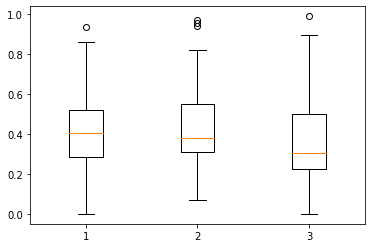

In [62]:
plt.boxplot([sequentialResultsArray[:,0,1],sequentialResultsArray[:,1,2],sequentialResultsArray[:,2,3]])

## While the distance to the initial query rises over time (unsurprisingly), the step size between consecutive queries remain roughly the same and rather small

In [63]:
from Levenshtein import ratio
def LevenshteinNormDist(dataset, txtCol):
    dt = dataset[txtCol].values
    if len(dt)==0:
        return (np.empty(shape=(0, 0)), 0)
    distMatrix = np.zeros((len(dt),len(dt)))
    for i,t1 in enumerate(dt):
        for j,t2 in enumerate(dt):
            distMatrix[i,j] = 1 - ratio(t1,t2)

    return (distMatrix,distMatrix.mean())


In [64]:
dMats4 = {}
for t in seqDFEmbeds.task.unique():
    for tm in seqDFEmbeds.team.unique():
        for u in seqDFEmbeds.user.unique():
            dt = seqDFEmbeds.loc[((seqDFEmbeds["task"]==t)&(seqDFEmbeds["team"]==tm)&(seqDFEmbeds["user"]==u))]
            dt = dt.sort_values("QueryRank")
            #print(dt.QueryRank)
            distMatrix, meanVal = LevenshteinNormDist(dt,"value")
            if len(distMatrix)>0:
                dMats4[(t,tm,u)] = distMatrix
            print (t, tm,u, meanVal)
dMats4 = pd.Series(dMats4)
sequentialResultsLevensteinArray = np.stack(dMats4.values)

vbs23-kis-t1 CVHunter 0 0.13701169487281456
vbs23-kis-t1 CVHunter 1 0.14893449065668954
vbs23-kis-t1 vitrivr-VR 0 0
vbs23-kis-t1 vitrivr-VR 1 0.36933238629274157
vbs23-kis-t1 VISIONE 0 0
vbs23-kis-t1 VISIONE 1 0
vbs23-kis-t1 vibro 0 0
vbs23-kis-t1 vibro 1 0
vbs23-kis-t2 CVHunter 0 0
vbs23-kis-t2 CVHunter 1 0
vbs23-kis-t2 vitrivr-VR 0 0.35638192508762623
vbs23-kis-t2 vitrivr-VR 1 0
vbs23-kis-t2 VISIONE 0 0
vbs23-kis-t2 VISIONE 1 0.09071640798448057
vbs23-kis-t2 vibro 0 0
vbs23-kis-t2 vibro 1 0
vbs23-kis-t3 CVHunter 0 0.39052962065257146
vbs23-kis-t3 CVHunter 1 0.19413782039640162
vbs23-kis-t3 vitrivr-VR 0 0
vbs23-kis-t3 vitrivr-VR 1 0
vbs23-kis-t3 VISIONE 0 0.22201951535331116
vbs23-kis-t3 VISIONE 1 0.08051149016316152
vbs23-kis-t3 vibro 0 0.26672105685557823
vbs23-kis-t3 vibro 1 0.3569093337754154
vbs23-kis-t4 CVHunter 0 0.2127426448052832
vbs23-kis-t4 CVHunter 1 0.1501677713081425
vbs23-kis-t4 vitrivr-VR 0 0.3473700718227917
vbs23-kis-t4 vitrivr-VR 1 0.3046875
vbs23-kis-t4 VISIONE 0 0

In [65]:
sequentialResultsLevensteinArray[:,0,:].mean(axis=0)#distances to first query

array([0.        , 0.26823764, 0.36473636, 0.43039336])

In [66]:
#distances to subsequent queries
print(
    sequentialResultsLevensteinArray[:,0,1].mean(),
    sequentialResultsLevensteinArray[:,1,2].mean(),
    sequentialResultsLevensteinArray[:,2,3].mean()
)

0.2682376441858279 0.24615518304602338 0.2010475184091708


In [67]:
ttest_ind(sequentialResultsLevensteinArray[:,0,1], sequentialResultsLevensteinArray[:,1,2])

Ttest_indResult(statistic=0.5298576585960664, pvalue=0.5975153593810427)

## Results of Levenstein distance support those of embeds distance. It seems that subsequent changes are a bit smaller for later reformulations, but no stat sign.

# Differences in sequences of query reformulations
- only users & tasks, where at least **3** text queries were made

In [114]:
dt = sortedData.loc[((sortedData.QueryRank <= 3)&(sortedData.MaxQueryRank >= 3))]
#cannot be done for verge as only one user is present
dt = dt.loc[dt.team != "Verge"]

stdf = dt.loc[dt.QT=="Text",'joint_text_embedding'].values
stdf = np.stack(stdf)
dfEmbeds = pd.DataFrame(stdf, columns=embedColnames, index=dt.loc[dt.QT=="Text"].index)
seqDFEmbeds = pd.concat([dt.loc[dt.QT=="Text"], dfEmbeds], axis=1)
seqDFEmbeds.shape

(119, 795)

In [115]:
dMats3 = {}
for t in seqDFEmbeds.task.unique():
    for tm in seqDFEmbeds.team.unique():
        for u in seqDFEmbeds.user.unique():
            dt = seqDFEmbeds.loc[((seqDFEmbeds["task"]==t)&(seqDFEmbeds["team"]==tm)&(seqDFEmbeds["user"]==u))]
            dt = dt.sort_values("QueryRank")
            #print(dt.QueryRank)
            distMatrix, meanVal = ILD_noRemove(dt,embedColnames)
            if len(distMatrix)>0:
                dMats3[(t,tm,u)] = distMatrix
            print (t, tm,u, meanVal)
dMats3 = pd.Series(dMats3)
sequentialResultsArray = np.stack(dMats3.values)

vbs23-kis-t2 vitrivr-VR 0 0.663911825175812
vbs23-kis-t2 vitrivr-VR 1 0
vbs23-kis-t2 CVHunter 0 0
vbs23-kis-t2 CVHunter 1 0
vbs23-kis-t2 VISIONE 0 0
vbs23-kis-t2 VISIONE 1 0
vbs23-kis-t2 vibro 0 0
vbs23-kis-t2 vibro 1 0
vbs23-kis-t3 vitrivr-VR 0 0
vbs23-kis-t3 vitrivr-VR 1 0
vbs23-kis-t3 CVHunter 0 0.3720782399202816
vbs23-kis-t3 CVHunter 1 0.233033676283166
vbs23-kis-t3 VISIONE 0 0.19862568070587158
vbs23-kis-t3 VISIONE 1 0.28352925765483694
vbs23-kis-t3 vibro 0 0
vbs23-kis-t3 vibro 1 0
vbs23-kis-t4 vitrivr-VR 0 0
vbs23-kis-t4 vitrivr-VR 1 0.560701421062544
vbs23-kis-t4 CVHunter 0 0.45692815087301447
vbs23-kis-t4 CVHunter 1 0.294838211008009
vbs23-kis-t4 VISIONE 0 0
vbs23-kis-t4 VISIONE 1 0
vbs23-kis-t4 vibro 0 0
vbs23-kis-t4 vibro 1 0
vbs23-kis-v-m2 vitrivr-VR 0 0
vbs23-kis-v-m2 vitrivr-VR 1 0
vbs23-kis-v-m2 CVHunter 0 0
vbs23-kis-v-m2 CVHunter 1 0
vbs23-kis-v-m2 VISIONE 0 0
vbs23-kis-v-m2 VISIONE 1 0.4075292698264678
vbs23-kis-v-m2 vibro 0 0
vbs23-kis-v-m2 vibro 1 0
vbs23-kis-v-m4 v

In [116]:
print(sequentialResultsArray[:,0,:].mean(axis=0)) #distances to first query

print(#distances to subsequent queries
    sequentialResultsArray[:,0,1].mean(),
    sequentialResultsArray[:,1,2].mean()
)

[0.         0.43713041 0.52649234 0.59270249 0.56969103 0.60808953
 0.65550886]
0.4371304103055936 0.38671734468277785


In [117]:
ttest_ind(sequentialResultsArray[:,0,1], sequentialResultsArray[:,1,2])

Ttest_indResult(statistic=0.8346717564467248, pvalue=0.41009079371997426)

In [118]:
dMats4 = {}
for t in seqDFEmbeds.task.unique():
    for tm in seqDFEmbeds.team.unique():
        for u in seqDFEmbeds.user.unique():
            dt = seqDFEmbeds.loc[((seqDFEmbeds["task"]==t)&(seqDFEmbeds["team"]==tm)&(seqDFEmbeds["user"]==u))]
            dt = dt.sort_values("QueryRank")
            #print(dt.QueryRank)
            distMatrix, meanVal = LevenshteinNormDist(dt,"value")
            if len(distMatrix)>0:
                dMats4[(t,tm,u)] = distMatrix
            print (t, tm,u, meanVal)
dMats4 = pd.Series(dMats4)
sequentialResultsLevensteinArray = np.stack(dMats4.values)

vbs23-kis-t2 vitrivr-VR 0 0.39694731759513746
vbs23-kis-t2 vitrivr-VR 1 0
vbs23-kis-t2 CVHunter 0 0
vbs23-kis-t2 CVHunter 1 0
vbs23-kis-t2 VISIONE 0 0
vbs23-kis-t2 VISIONE 1 0
vbs23-kis-t2 vibro 0 0
vbs23-kis-t2 vibro 1 0
vbs23-kis-t3 vitrivr-VR 0 0
vbs23-kis-t3 vitrivr-VR 1 0
vbs23-kis-t3 CVHunter 0 0.3863366101030397
vbs23-kis-t3 CVHunter 1 0.24799680324372864
vbs23-kis-t3 VISIONE 0 0.20609024039317048
vbs23-kis-t3 VISIONE 1 0.14932654061431075
vbs23-kis-t3 vibro 0 0
vbs23-kis-t3 vibro 1 0
vbs23-kis-t4 vitrivr-VR 0 0
vbs23-kis-t4 vitrivr-VR 1 0.44052099780295156
vbs23-kis-t4 CVHunter 0 0.30887477785872175
vbs23-kis-t4 CVHunter 1 0.1711716018599616
vbs23-kis-t4 VISIONE 0 0
vbs23-kis-t4 VISIONE 1 0
vbs23-kis-t4 vibro 0 0
vbs23-kis-t4 vibro 1 0
vbs23-kis-v-m2 vitrivr-VR 0 0
vbs23-kis-v-m2 vitrivr-VR 1 0
vbs23-kis-v-m2 CVHunter 0 0
vbs23-kis-v-m2 CVHunter 1 0
vbs23-kis-v-m2 VISIONE 0 0
vbs23-kis-v-m2 VISIONE 1 0.31699971866350946
vbs23-kis-v-m2 vibro 0 0
vbs23-kis-v-m2 vibro 1 0
vbs23-ki

In [119]:
print(sequentialResultsLevensteinArray[:,0,:].mean(axis=0)) #distances to first query

print(#distances to subsequent queries
    sequentialResultsLevensteinArray[:,0,1].mean(),
    sequentialResultsLevensteinArray[:,1,2].mean()
)

[0.         0.2957012  0.40417259 0.44063317 0.46168483 0.47753833
 0.52725418]
0.29570120123084914 0.24886413921054348


In [74]:
ttest_ind(sequentialResultsLevensteinArray[:,0,1], sequentialResultsLevensteinArray[:,1,2])

Ttest_indResult(statistic=-0.17477064456781688, pvalue=0.861544897710099)

# Differences in sequences of query reformulations
- only users & tasks, where at least **5** text queries were made

In [109]:
dt = sortedData.loc[((sortedData.QueryRank <= 5)&(sortedData.MaxQueryRank >= 5))]
#cannot be done for verge as only one user is present
dt = dt.loc[dt.team != "Verge"]

stdf = dt.loc[dt.QT=="Text",'joint_text_embedding'].values
stdf = np.stack(stdf)
dfEmbeds = pd.DataFrame(stdf, columns=embedColnames, index=dt.loc[dt.QT=="Text"].index)
seqDFEmbeds = pd.concat([dt.loc[dt.QT=="Text"], dfEmbeds], axis=1)
seqDFEmbeds.shape

(160, 795)

In [110]:
dMats3 = {}
for t in seqDFEmbeds.task.unique():
    for tm in seqDFEmbeds.team.unique():
        for u in seqDFEmbeds.user.unique():
            dt = seqDFEmbeds.loc[((seqDFEmbeds["task"]==t)&(seqDFEmbeds["team"]==tm)&(seqDFEmbeds["user"]==u))]
            dt = dt.sort_values("QueryRank")
            #print(dt.QueryRank)
            distMatrix, meanVal = ILD_noRemove(dt,embedColnames)
            if len(distMatrix)>0:
                dMats3[(t,tm,u)] = distMatrix
            print (t, tm,u, meanVal)
dMats3 = pd.Series(dMats3)
sequentialResultsArray = np.stack(dMats3.values)

vbs23-kis-t1 CVHunter 0 0.3204608863792549
vbs23-kis-t1 CVHunter 1 0
vbs23-kis-t1 VISIONE 0 0
vbs23-kis-t1 VISIONE 1 0
vbs23-kis-t1 vitrivr-VR 0 0
vbs23-kis-t1 vitrivr-VR 1 0
vbs23-kis-t1 vibro 0 0
vbs23-kis-t1 vibro 1 0
vbs23-kis-t2 CVHunter 0 0
vbs23-kis-t2 CVHunter 1 0
vbs23-kis-t2 VISIONE 0 0
vbs23-kis-t2 VISIONE 1 0.2846444253950371
vbs23-kis-t2 vitrivr-VR 0 0.6427518399900716
vbs23-kis-t2 vitrivr-VR 1 0
vbs23-kis-t2 vibro 0 0
vbs23-kis-t2 vibro 1 0
vbs23-kis-t3 CVHunter 0 0.35245335366070873
vbs23-kis-t3 CVHunter 1 0.20889489450373944
vbs23-kis-t3 VISIONE 0 0.14649448012392802
vbs23-kis-t3 VISIONE 1 0.21091126562372564
vbs23-kis-t3 vitrivr-VR 0 0
vbs23-kis-t3 vitrivr-VR 1 0
vbs23-kis-t3 vibro 0 0
vbs23-kis-t3 vibro 1 0.37073323733946767
vbs23-kis-t4 CVHunter 0 0.36113288259727966
vbs23-kis-t4 CVHunter 1 0.2760300691261661
vbs23-kis-t4 VISIONE 0 0
vbs23-kis-t4 VISIONE 1 0.3892132167882514
vbs23-kis-t4 vitrivr-VR 0 0.5380338061054127
vbs23-kis-t4 vitrivr-VR 1 0.4321638398347129
vbs

In [111]:
print(sequentialResultsArray[:,0,:].mean(axis=0)) #distances to first query

print(#distances to subsequent queries
    sequentialResultsArray[:,0,1].mean(),
    sequentialResultsArray[:,1,2].mean(),
    sequentialResultsArray[:,2,3].mean(),
    sequentialResultsArray[:,3,4].mean(),
    #sequentialResultsArray[:,4,5].mean()
)

[0.         0.41119852 0.52558934 0.56846732 0.57932339]
0.41119852197541507 0.3956562862191203 0.3383253211980942 0.33307586824665314


In [112]:
dMats4 = {}
for t in seqDFEmbeds.task.unique():
    for tm in seqDFEmbeds.team.unique():
        for u in seqDFEmbeds.user.unique():
            dt = seqDFEmbeds.loc[((seqDFEmbeds["task"]==t)&(seqDFEmbeds["team"]==tm)&(seqDFEmbeds["user"]==u))]
            dt = dt.sort_values("QueryRank")
            #print(dt.QueryRank)
            distMatrix, meanVal = LevenshteinNormDist(dt,"value")
            if len(distMatrix)>0:
                dMats4[(t,tm,u)] = distMatrix
            print (t, tm,u, meanVal)
dMats4 = pd.Series(dMats4)
sequentialResultsLevensteinArray = np.stack(dMats4.values)

vbs23-kis-t1 CVHunter 0 0.22027721217206292
vbs23-kis-t1 CVHunter 1 0
vbs23-kis-t1 VISIONE 0 0
vbs23-kis-t1 VISIONE 1 0
vbs23-kis-t1 vitrivr-VR 0 0
vbs23-kis-t1 vitrivr-VR 1 0
vbs23-kis-t1 vibro 0 0
vbs23-kis-t1 vibro 1 0
vbs23-kis-t2 CVHunter 0 0
vbs23-kis-t2 CVHunter 1 0
vbs23-kis-t2 VISIONE 0 0
vbs23-kis-t2 VISIONE 1 0.13136336364943785
vbs23-kis-t2 vitrivr-VR 0 0.4047940785739465
vbs23-kis-t2 vitrivr-VR 1 0
vbs23-kis-t2 vibro 0 0
vbs23-kis-t2 vibro 1 0
vbs23-kis-t3 CVHunter 0 0.4072567917211407
vbs23-kis-t3 CVHunter 1 0.2322698975804111
vbs23-kis-t3 VISIONE 0 0.19780540140584535
vbs23-kis-t3 VISIONE 1 0.0775287563576858
vbs23-kis-t3 vitrivr-VR 0 0
vbs23-kis-t3 vitrivr-VR 1 0
vbs23-kis-t3 vibro 0 0
vbs23-kis-t3 vibro 1 0.38376671831036774
vbs23-kis-t4 CVHunter 0 0.22690151100518882
vbs23-kis-t4 CVHunter 1 0.15994240765081663
vbs23-kis-t4 VISIONE 0 0
vbs23-kis-t4 VISIONE 1 0.25866809922898126
vbs23-kis-t4 vitrivr-VR 0 0.39731968392770534
vbs23-kis-t4 vitrivr-VR 1 0.33335032437442075


In [113]:
print(sequentialResultsLevensteinArray[:,0,:].mean(axis=0)) #distances to first query

print(#distances to subsequent queries
    sequentialResultsLevensteinArray[:,0,1].mean(),
    sequentialResultsLevensteinArray[:,1,2].mean(),
    sequentialResultsLevensteinArray[:,2,3].mean(),
    sequentialResultsLevensteinArray[:,3,4].mean(),
    #sequentialResultsLevensteinArray[:,4,5].mean()
    
)

[0.         0.25904256 0.37823288 0.42364564 0.46842595]
0.2590425647455963 0.24354493272847086 0.1793569918598752 0.19305986010423623


# Differences in sequences of query reformulations
- only users & tasks, where at least **4** text queries were made
- selecting last 4 queries

In [80]:
dt = sortedData.loc[((sortedData.DiffFromMaxQueryRank >= -3)&(sortedData.MaxQueryRank >= 4))]
#cannot be done for verge as only one user is present
dt = dt.loc[dt.team != "Verge"]

stdf = dt.loc[dt.QT=="Text",'joint_text_embedding'].values
stdf = np.stack(stdf)
dfEmbeds = pd.DataFrame(stdf, columns=embedColnames, index=dt.loc[dt.QT=="Text"].index)
seqDFEmbeds = pd.concat([dt.loc[dt.QT=="Text"], dfEmbeds], axis=1)
seqDFEmbeds.shape

(184, 795)

In [81]:
dMats3 = {}
for t in seqDFEmbeds.task.unique():
    for tm in seqDFEmbeds.team.unique():
        for u in seqDFEmbeds.user.unique():
            dt = seqDFEmbeds.loc[((seqDFEmbeds["task"]==t)&(seqDFEmbeds["team"]==tm)&(seqDFEmbeds["user"]==u))]
            dt = dt.sort_values("QueryRank")
            #print(dt.QueryRank)
            distMatrix, meanVal = ILD_noRemove(dt,embedColnames)
            if len(distMatrix)>0:
                dMats3[(t,tm,u)] = distMatrix
            print (t, tm,u, meanVal)
dMats3 = pd.Series(dMats3)
sequentialResultsArray = np.stack(dMats3.values)

vbs23-kis-t1 CVHunter 0 0.284206300080437
vbs23-kis-t1 CVHunter 1 0.21095714138323995
vbs23-kis-t1 vitrivr-VR 0 0
vbs23-kis-t1 vitrivr-VR 1 0.574684088732962
vbs23-kis-t1 VISIONE 0 0
vbs23-kis-t1 VISIONE 1 0
vbs23-kis-t1 vibro 0 0
vbs23-kis-t1 vibro 1 0
vbs23-kis-t2 CVHunter 0 0
vbs23-kis-t2 CVHunter 1 0
vbs23-kis-t2 vitrivr-VR 0 0.3735710951200335
vbs23-kis-t2 vitrivr-VR 1 0
vbs23-kis-t2 VISIONE 0 0
vbs23-kis-t2 VISIONE 1 0.19768730093793774
vbs23-kis-t2 vibro 0 0
vbs23-kis-t2 vibro 1 0
vbs23-kis-t3 CVHunter 0 0.2181340300070374
vbs23-kis-t3 CVHunter 1 0.14164195557292938
vbs23-kis-t3 vitrivr-VR 0 0
vbs23-kis-t3 vitrivr-VR 1 0
vbs23-kis-t3 VISIONE 0 0.17582654247167084
vbs23-kis-t3 VISIONE 1 0.17952915627507915
vbs23-kis-t3 vibro 0 0.38946043200614144
vbs23-kis-t3 vibro 1 0.36220561942721774
vbs23-kis-t4 CVHunter 0 0.33709583870625676
vbs23-kis-t4 CVHunter 1 0.15800771004917322
vbs23-kis-t4 vitrivr-VR 0 0.5217442703181461
vbs23-kis-t4 vitrivr-VR 1 0.5484679213858833
vbs23-kis-t4 VISIO

In [89]:
print(sequentialResultsArray[:,3,:].mean(axis=0)) #distances to first query

print(#distances to subsequent queries
    sequentialResultsArray[:,0,1].mean(),
    sequentialResultsArray[:,1,2].mean(),
    sequentialResultsArray[:,2,3].mean()
)

[0.52065462 0.45845817 0.35358167 0.        ]
0.38070343353736436 0.3363264549580961 0.3535816681794813


In [83]:
ttest_ind(sequentialResultsArray[:,0,1], sequentialResultsArray[:,1,2])

Ttest_indResult(statistic=0.9245504808850588, pvalue=0.35767209417145407)

{'whiskers': [<matplotlib.lines.Line2D at 0x1ba906e1430>,
 'caps': [<matplotlib.lines.Line2D at 0x1ba906e1af0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ba906e10d0>,
 'medians': [<matplotlib.lines.Line2D at 0x1ba906eb1f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1ba906eb550>,
 'means': []}

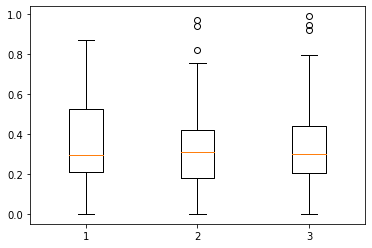

In [84]:
plt.boxplot([sequentialResultsArray[:,0,1],sequentialResultsArray[:,1,2],sequentialResultsArray[:,2,3]])

In [85]:
dMats4 = {}
for t in seqDFEmbeds.task.unique():
    for tm in seqDFEmbeds.team.unique():
        for u in seqDFEmbeds.user.unique():
            dt = seqDFEmbeds.loc[((seqDFEmbeds["task"]==t)&(seqDFEmbeds["team"]==tm)&(seqDFEmbeds["user"]==u))]
            dt = dt.sort_values("QueryRank")
            #print(dt.QueryRank)
            distMatrix, meanVal = LevenshteinNormDist(dt,"value")
            if len(distMatrix)>0:
                dMats4[(t,tm,u)] = distMatrix
            print (t, tm,u, meanVal)
dMats4 = pd.Series(dMats4)
sequentialResultsLevensteinArray = np.stack(dMats4.values)

vbs23-kis-t1 CVHunter 0 0.22900897856166402
vbs23-kis-t1 CVHunter 1 0.14893449065668954
vbs23-kis-t1 vitrivr-VR 0 0
vbs23-kis-t1 vitrivr-VR 1 0.36933238629274157
vbs23-kis-t1 VISIONE 0 0
vbs23-kis-t1 VISIONE 1 0
vbs23-kis-t1 vibro 0 0
vbs23-kis-t1 vibro 1 0
vbs23-kis-t2 CVHunter 0 0
vbs23-kis-t2 CVHunter 1 0
vbs23-kis-t2 vitrivr-VR 0 0.2376763290635848
vbs23-kis-t2 vitrivr-VR 1 0
vbs23-kis-t2 VISIONE 0 0
vbs23-kis-t2 VISIONE 1 0.12250506270890912
vbs23-kis-t2 vibro 0 0
vbs23-kis-t2 vibro 1 0
vbs23-kis-t3 CVHunter 0 0.15604220462796983
vbs23-kis-t3 CVHunter 1 0.0733593115619966
vbs23-kis-t3 vitrivr-VR 0 0
vbs23-kis-t3 vitrivr-VR 1 0
vbs23-kis-t3 VISIONE 0 0.08649333775636714
vbs23-kis-t3 VISIONE 1 0.11456705434613673
vbs23-kis-t3 vibro 0 0.26672105685557823
vbs23-kis-t3 vibro 1 0.3904444905987283
vbs23-kis-t4 CVHunter 0 0.1452827912256306
vbs23-kis-t4 CVHunter 1 0.05845408636694234
vbs23-kis-t4 vitrivr-VR 0 0.40077692050451663
vbs23-kis-t4 vitrivr-VR 1 0.4133044082632322
vbs23-kis-t4 VI

In [86]:
print(sequentialResultsLevensteinArray[:,0,:].mean(axis=0)) #distances to first query

print(#distances to subsequent queries
    sequentialResultsLevensteinArray[:,0,1].mean(),
    sequentialResultsLevensteinArray[:,1,2].mean()
)

[0.         0.21685172 0.26047136 0.35035106]
0.2168517162179248 0.16546381111154926


In [87]:
ttest_ind(sequentialResultsLevensteinArray[:,0,1], sequentialResultsLevensteinArray[:,1,2])

Ttest_indResult(statistic=1.3528282629044268, pvalue=0.17949933664486573)